# <img src="https://img.icons8.com/bubbles/50/000000/mind-map.png" style="height:50px;display:inline"> ECE 046211 - Technion - Deep Learning - Project
---

## "Mind the Gap" - A Deep Learning Analysis of Pothole Detection
---

|      Name    |      Campus Email              | Personal Email        |
|--------------|--------------------------------|-----------------------|
|Itai Benyamin | itai.b@campus.technion.ac.il         |itai.benyamin@gmail.com|
|Idan Baruch   | idan-b@campus.technion.ac.il|idanb12200@gmail.com  |

## Introduction


In [69]:
import os
import shutil
import xmltodict
import random
import numpy as np
import pandas as pd
import time
import copy
import re
from enum import Enum
import cv2
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader, Subset
import torchvision
from torchmetrics.detection import MeanAveragePrecision
from torchvision.models.detection import FasterRCNN_ResNet50_FPN_Weights
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import kagglehub as kh
from tqdm import tqdm

# Set random seed for reproducibility
seed = 211
np.random.seed(seed)
torch.manual_seed(seed)

# Enable inline plotting for Jupyter notebooks
%matplotlib inline

# device - cpu or gpu?
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
pin_memory = True if device == "cuda:0" else False

print("pytorch version:", torch.__version__)
print("torchvision version:", torchvision.__version__)
print("Is CUDA available:", torch.cuda.is_available())
print("CUDA version:", torch.version.cuda)
print("PyTorch built with CUDA:", torch.backends.cuda.is_built())
print("Available devices:", torch.cuda.device_count())
print("Current device:", torch.cuda.get_device_name(torch.cuda.current_device()) if torch.cuda.is_available() else "No device")

pytorch version: 2.5.1
torchvision version: 0.20.1
Is CUDA available: True
CUDA version: 11.8
PyTorch built with CUDA: True
Available devices: 1
Current device: NVIDIA GeForce RTX 3090


## Part 1 - Data Loading

In [16]:
kaggle_datapath = 'andrewmvd/pothole-detection'
if not os.path.exists('data'):
    #Load the data from kaggle
    data_path = kh.dataset_download(kaggle_datapath)
    # Move the data to the correct location
    shutil.move(data_path, 'data')
else:
    print('Data already exists')

Data already exists


In [23]:
class PotholeSeverity(Enum):
    """
    Enum class for the severity of potholes.
    The severity levels ranges from 0 (no pothole) to 4 (major pothole):
        0 - No pothole (background, shouldn't be a detection target)
        temporary 1 - general pothole, no specific severity)
        1 - Minor pothole (road damage that is non-dangerous for padestrians)
        2 - Medium pothole (road damage that is dangerous for padestrians, but not for vehicles)
        3 - Major pothole (road damage that is dangerous for both vehicles and padestrians)
    """
    NO_POTHOLE = 0
    POTHOLE = 1 # TODO - this label is for temporary until we classify each saverity in the data.
    #MINOR_POTHOLE = 1
    #MEDIUM_POTHOLE = 2
    #MAJOR_POTHOLE = 3

def get_label_name(label):
    return PotholeSeverity(label).name

class PotholeDetectionDataset:
    def __init__(self, img_dir, ann_dir, transform=None):
        self.img_dir = img_dir
        self.ann_dir = ann_dir
        self.transform = transform
        
        # Preprocess data
        self.img_files, self.ann_files = self._preprocess_dataset()

    
    @staticmethod
    def _extract_index(filename):
        # Use a regex to extract the numeric index from the file name
        match = re.search(r'\d+', filename)
        return int(match.group()) if match else float('inf')

    def _preprocess_dataset(self):
        # Get images from folder
        img_files = sorted(os.listdir(self.img_dir), key=self._extract_index)
        ann_files = sorted(os.listdir(self.ann_dir), key=self._extract_index)

        valid_img_files = []
        valid_ann_files = []

        # Parse images and annotated boxes to return only the valid images and boxes
        for img_file, ann_file in zip(img_files, ann_files):
            img_path = os.path.join(self.img_dir, img_file)
            ann_path = os.path.join(self.ann_dir, ann_file)
            
            # Load and validate
            img = cv2.imread(img_path)
            img_height, img_width = img.shape[:2]
            boxes, _ = self.parse_voc_annotation(ann_path)
            
            if self._check_boxes_validity(boxes, img_width, img_height):
                valid_img_files.append(img_file)
                valid_ann_files.append(ann_file)
                assert len(valid_img_files) == len(valid_ann_files)
        
        print(f'Number of valid images: {len(valid_img_files)}')
        return valid_img_files, valid_ann_files
    
    @staticmethod
    def _check_boxes_validity(boxes, img_width, img_height):
        for xmin, ymin, xmax, ymax in boxes:
            width = xmax - xmin
            height = ymax - ymin
            
            if width <= 0 or height <= 0:
                return False
            if xmin < 0 or ymin < 0 or xmax > img_width or ymax > img_height:
                return False
        return True

    def parse_voc_annotation(self, ann_path):
        with open(ann_path) as f:
            ann_data = xmltodict.parse(f.read())
        
        boxes = []
        labels = []
        objects = ann_data["annotation"].get("object", [])
        if not isinstance(objects, list):
            objects = [objects]
        
        for obj in objects:
            bbox = obj["bndbox"]
            xmin = int(float(bbox["xmin"]))
            ymin = int(float(bbox["ymin"]))
            xmax = int(float(bbox["xmax"]))
            ymax = int(float(bbox["ymax"]))
            boxes.append((xmin, ymin, xmax, ymax))
            labels.append(PotholeSeverity.POTHOLE.value)
        
        return boxes, labels
    
    def __len__(self):
        return len(self.img_files)
    
    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_files[idx])
        ann_path = os.path.join(self.ann_dir, self.ann_files[idx])
        
        # Load image
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        original_size = img.shape[:2]  # (height, width)
        
        # Load annotations
        boxes, labels = self.parse_voc_annotation(ann_path)
        
        # Apply transform
        if self.transform is not None:
            img_pil = torchvision.transforms.ToPILImage()(img)
            img = self.transform(img_pil)
            new_size = (img.shape[2], img.shape[1])  # (width, height)
            
            # Adjust bounding boxes
            orig_h, orig_w = original_size
            new_w, new_h = new_size
            x_scale = new_w / orig_w
            y_scale = new_h / orig_h
            boxes = [
                (int(xmin * x_scale), int(ymin * y_scale), int(xmax * x_scale), int(ymax * y_scale))
                for xmin, ymin, xmax, ymax in boxes
            ]
            
            target = {
                "boxes": torch.tensor(boxes, dtype=torch.float32),
                "labels": torch.tensor(labels, dtype=torch.int64),
                "image_id": torch.tensor([idx], dtype=torch.int64),
                "area": torch.tensor([(xmax - xmin) * (ymax - ymin) for xmin, ymin, xmax, ymax in boxes], dtype=torch.float32),
                "iscrowd": torch.zeros((len(boxes),), dtype=torch.int64)
            }

        
        return img, target
    
# custom collate_fn for torch DataLoader
def collate_fn(batch):
    return tuple(zip(*batch))

In [24]:
# Paths to images and annotations
img_dir = "./data/images"
ann_dir = "./data/annotations"

transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize((480, 480)),
    torchvision.transforms.ToTensor(), # uint8 values in [0, 255] -> float tensor with values [0, 1]
])

# Initialize the dataset
dataset = PotholeDetectionDataset(img_dir, ann_dir, transform=transform)

# Split the dataset to train, validation, and test sets (70-10-20)
#train_set, test_set = train_test_split(dataset, test_size=0.2, random_state=seed)
#train_set, val_set = train_test_split(train_set, test_size=0.125, random_state=seed)

# Maintain the original indices while splitting
train_indices, test_indices = train_test_split(range(len(dataset)), test_size=0.2, random_state=seed)
train_indices, val_indices = train_test_split(train_indices, test_size=0.125, random_state=seed)

train_set = Subset(dataset, train_indices)
val_set = Subset(dataset, val_indices)
test_set = Subset(dataset, test_indices)

print(f"Train set size: {len(train_set)} - {len(train_set)/len(dataset)*100:.2f}%")
print(f"Validation set size: {len(val_set)} - {len(val_set)/len(dataset)*100:.2f}%")
print(f"Test set size: {len(test_set)} - {len(test_set)/len(dataset)*100:.2f}%")

Number of valid images: 663
Train set size: 463 - 69.83%
Validation set size: 67 - 10.11%
Test set size: 133 - 20.06%


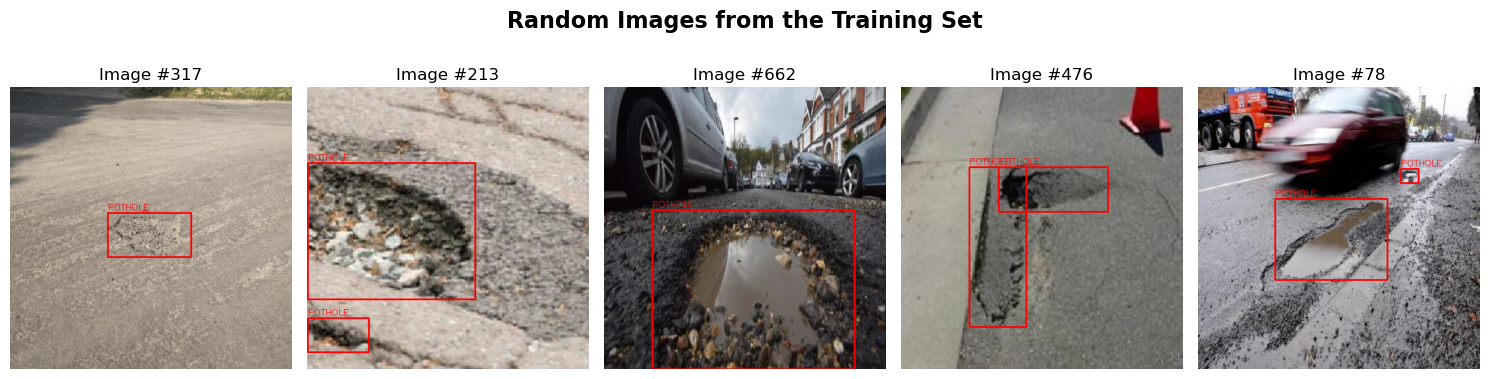

In [29]:
# Display 5 random images from the training set
train_loader = DataLoader(train_set, batch_size=5, shuffle=True, collate_fn=collate_fn)
images, targets = next(iter(train_loader))

fig, axs = plt.subplots(1, len(images), figsize=(15, 5))

for i, (img, target) in enumerate(zip(images, targets)):
    img_np = img.permute(1, 2, 0).numpy()  # Convert to (H, W, C) format
    img_np = (img_np * 255).astype(np.uint8).copy()  # Scale and convert to uint8
    
    for box, label in zip(target["boxes"], target["labels"]):
        cv2.rectangle(img_np, (int(box[0]), int(box[1])), (int(box[2]), int(box[3])), (255, 0, 0), 2)
        label = get_label_name(target["labels"][0].item())
        cv2.putText(img_np, label, (int(box[0]), int(box[1] - 5)), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 1)
    
    
    axs[i].imshow(img_np)
    axs[i].axis("off")
    axs[i].set_title(f"Image #{target['image_id'].item()}")

# Add a main title
plt.suptitle("Random Images from the Training Set", fontsize=16, fontweight="bold", y=0.9)

plt.tight_layout()
plt.show()


## Part 2 - CNN

In [ ]:
# TODO - for later, creating a custom loss function.

def custom_loss_fn(predictions, targets):
    """
    Custom loss for object detection.
    Args:
        predictions: Dictionary containing 'logits' and 'boxes'.
        targets: Dictionary containing 'labels' and 'boxes'.
    Returns:
        Total loss: Combined classification and regression loss.
    """
    pred_logits = predictions['logits']
    pred_boxes = predictions['boxes']
    target_labels = targets['labels']
    target_boxes = targets['boxes']

    # 1. Classification Loss with penalty for mislabeling
    # Define weights: Higher penalty for incorrect classifications
    weights = torch.ones_like(pred_logits)
    weights[target_labels != pred_logits.argmax(dim=1)] *= 2.0  # Penalize mislabeling
    classification_loss = F.cross_entropy(pred_logits, target_labels, weight=weights)

    # 2. Bounding Box Loss with IoU-based adjustments
    # Compute IoU between predicted and target boxes
    iou = compute_iou(pred_boxes, target_boxes)
    
    # Apply less impact for close detections (IoU > 0.5)
    regression_loss = torch.where(
        iou > 0.5,
        torch.nn.functional.smooth_l1_loss(pred_boxes, target_boxes, reduction='none') * (1 - iou),  # Scale by IoU
        torch.nn.functional.smooth_l1_loss(pred_boxes, target_boxes, reduction='none')
    ).mean()

    # Combine losses
    total_loss = classification_loss + regression_loss
    return total_loss

def compute_iou(boxes1, boxes2):
    """
    Compute IoU (Intersection over Union) between two sets of boxes.
    Args:
        boxes1: Tensor of shape (N, 4).
        boxes2: Tensor of shape (N, 4).
    Returns:
        IoU scores: Tensor of shape (N,).
    """
    # Calculate intersection
    inter_x1 = torch.max(boxes1[:, 0], boxes2[:, 0])
    inter_y1 = torch.max(boxes1[:, 1], boxes2[:, 1])
    inter_x2 = torch.min(boxes1[:, 2], boxes2[:, 2])
    inter_y2 = torch.min(boxes1[:, 3], boxes2[:, 3])

    inter_area = torch.clamp(inter_x2 - inter_x1, min=0) * torch.clamp(inter_y2 - inter_y1, min=0)

    # Calculate union
    area1 = (boxes1[:, 2] - boxes1[:, 0]) * (boxes1[:, 3] - boxes1[:, 1])
    area2 = (boxes2[:, 2] - boxes2[:, 0]) * (boxes2[:, 3] - boxes2[:, 1])
    union_area = area1 + area2 - inter_area

    # IoU
    iou = inter_area / union_area
    return iou

In [ ]:
# Training function
# TODO - explain the trade-off between batch size and number of epochs
# TODO -add validation check
def train(model, traim_loader, val_loader, optimizer, lr_scheduler, num_epochs):
    train_losses = []
    val_losses = []

    # Training loop
    for epoch in range(num_epochs):
        model.train()
        epoch_train_loss = 0.0
        for images, targets in train_loader:
            # Prepare inputs for the model
            images = [img.to(device) for img in images]
            # Convert relevant target values to device
            targets_to_device = []
            for target in targets:
                targets_to_device.append({
                    'boxes': target['boxes'].to(device),
                    'labels': target['labels'].to(device)
                })

            # Compute loss
            loss_dict = model(images, targets_to_device)
            losses = sum(loss for loss in loss_dict.values())
            epoch_train_loss += losses.item()

            # Backpropagation
            optimizer.zero_grad()
            losses.backward()
            optimizer.step()

        # Step the learning rate scheduler
        lr_scheduler.step()

        print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_train_loss:.4f}")

    # Save the trained model
    model_name = f"faster_rcnn_pothole_{batch_size}.pth"
    torch.save(model.state_dict(), model_name)
    print(f"Model training complete. Saved as '{model_name}'")
    
    # Return the losses
    return train_losses, val_losses


# Train the model over different batch sizes
results = {}
for batch_size in [2, 4, 8, 16, 32]:
   # TODO - explain what is the loss function that is used.
    # Define the model (load pretrained weights of Resnet50-FPN on COCO_V1 dataset)
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1)

    # Replace the classifier with a single-class output
    num_classes = len(PotholeSeverity)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(in_features, num_classes)

    # Move model to GPU
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    # Define optimizer and learning rate scheduler
    # TODO - explain chosen hyperparameters
    optimizer = torch.optim.SGD(model.parameters(),lr=0.005,momentum=0.9,weight_decay=0.0005)
    lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)
    
    # Create data loaders
    train_loader = DataLoader(train_set,batch_size=batch_size,shuffle=True,collate_fn=collate_fn)
    val_loader = DataLoader(val_set,batch_size=batch_size,shuffle=False,collate_fn=collate_fn)
    
    # TODO: check if need to run 10 to 100 epochs and not 100 right away and collect best epoch num
    #for num_epochs in [10, 20, 50, 100]:
    
    train_losses, val_losses = train(model, train_loader, val_loader, optimizer, lr_scheduler, num_epochs=5)
    results[batch_size] = (train_losses, val_losses)

Epoch 1/5, Loss: 80.1004
Epoch 2/5, Loss: 61.8072
Epoch 3/5, Loss: 48.4790
Epoch 4/5, Loss: 33.6874
Epoch 5/5, Loss: 29.5919
Model training complete. Saved as 'faster_rcnn_pothole_2.pth'
Epoch 1/5, Loss: 13.5722
Epoch 2/5, Loss: 12.9858
Epoch 3/5, Loss: 13.0028
Epoch 4/5, Loss: 12.9612
Epoch 5/5, Loss: 12.8312
Model training complete. Saved as 'faster_rcnn_pothole_4.pth'
Epoch 1/5, Loss: 6.4127
Epoch 2/5, Loss: 6.4458
Epoch 3/5, Loss: 6.3856
Epoch 4/5, Loss: 6.3997
Epoch 5/5, Loss: 6.3832
Model training complete. Saved as 'faster_rcnn_pothole_8.pth'
Epoch 1/5, Loss: 3.2017
Epoch 2/5, Loss: 3.2096
Epoch 3/5, Loss: 3.2227
Epoch 4/5, Loss: 3.2079
Epoch 5/5, Loss: 3.1970
Model training complete. Saved as 'faster_rcnn_pothole_16.pth'


OutOfMemoryError: CUDA out of memory. Tried to allocate 1.22 GiB. GPU 0 has a total capacity of 23.68 GiB of which 929.38 MiB is free. Including non-PyTorch memory, this process has 22.38 GiB memory in use. Of the allocated memory 20.10 GiB is allocated by PyTorch, and 1.95 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [ ]:
# Visualize the results
for batch_size, (train_losses, val_losses) in results.items():
    plt.plot(range(5), train_losses, label=f"Train Loss (Batch Size: {batch_size})")
    plt.plot(range(5), val_losses, label=f"Validation Loss (Batch Size: {batch_size})")

In [73]:
# TODO - explain what is the loss function that is used.
# Define the dataset and DataLoader
train_loader = DataLoader(
    train_set,
    batch_size=8,
    shuffle=True,
    collate_fn=collate_fn
)

val_loader = DataLoader(
    val_set,
    batch_size=4,
    shuffle=False,
    collate_fn=collate_fn
)

# Define the model (load pretrained weights of Resnet50-FPN on COCO_V1 dataset)
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1)

# Replace the classifier with a single-class output
num_classes = len(PotholeSeverity)
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(in_features, num_classes)

# Move model to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define optimizer and learning rate scheduler
# TODO - explain chosen hyperparameters
optimizer = torch.optim.SGD(
    model.parameters(),
    lr=0.005,
    momentum=0.9,
    weight_decay=0.0005
)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

# Training loop
# TODO - explain the trade-off between batch size and number of epochs
# TODO -add validation check
num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    for images, targets in train_loader:
        # Prepare inputs for the model
        images = [img.to(device) for img in images]
        #targets = [{k: v.to(device) for k, v in target.items()} for target in targets]
        # Convert relevant target values to device
        targets_to_device = []
        for target in targets:
            targets_to_device.append({
                'boxes': target['boxes'].to(device),
                'labels': target['labels'].to(device)
            })
    
        
        # Compute loss
        loss_dict = model(images, targets_to_device)
        losses = sum(loss for loss in loss_dict.values())
        epoch_loss += losses.item()
        
        # Backpropagation
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
    
    # Step the learning rate scheduler
    lr_scheduler.step()
    
    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss:.4f}")

# Save the trained model
torch.save(model.state_dict(), "faster_rcnn_pothole.pth")
print("Model training complete. Saved as 'faster_rcnn_pothole.pth'.")

Epoch 1/20, Loss: 24.6768
Epoch 2/20, Loss: 15.9249
Epoch 3/20, Loss: 12.6866
Epoch 4/20, Loss: 9.8223
Epoch 5/20, Loss: 9.2794
Epoch 6/20, Loss: 8.8755
Epoch 7/20, Loss: 8.6593
Epoch 8/20, Loss: 8.6372
Epoch 9/20, Loss: 8.5593
Epoch 10/20, Loss: 8.5513
Epoch 11/20, Loss: 8.5102
Epoch 12/20, Loss: 8.5278
Epoch 13/20, Loss: 8.5089
Epoch 14/20, Loss: 8.4884
Epoch 15/20, Loss: 8.5059
Epoch 16/20, Loss: 8.5141
Epoch 17/20, Loss: 8.4784
Epoch 18/20, Loss: 8.4783
Epoch 19/20, Loss: 8.5076
Epoch 20/20, Loss: 8.5361
Model training complete. Saved as 'faster_rcnn_pothole.pth'.


In [63]:
# Function to calculate test score (e.g., mean Average Precision)
def evaluate_model(model, data_loader, threshold=0.5):
    model.eval()  # Ensure the model is in evaluation mode
    all_predictions = {}
    #all_ground_truths = {}
    
    with torch.no_grad():
        for batch_idx, (images, targets) in enumerate(data_loader):
            # Prepare images for inference
            inputs = [img.to(device) for img in images]
            
            # Run model inference
            outputs = model(inputs)
            #print(f"Outputs for batch {batch_idx}: {outputs}")
            # Collect predictions and ground truth
            for i, (output, target) in enumerate(zip(outputs, targets)):
                image_id = target["image_id"].item()
                gt_boxes = target["boxes"].cpu().numpy().tolist()
                
                predictions = [
                    (box.tolist(), label.item(), score.item())
                    for box, label, score in zip(output['boxes'], output['labels'], output['scores'])
                    if score >= threshold
                ]
                all_predictions[image_id] = predictions
    return all_predictions

In [64]:
def visualize_predictions(images, targets, all_predictions, threshold=0.5, show_severity=False):
    fig, axs = plt.subplots(1, len(images), figsize=(15, 5))

    for i, (img, target) in enumerate(zip(images, targets)):
        img_np = img.permute(1, 2, 0).numpy()  # Convert to (H, W, C) format
        img_np = (img_np * 255).astype(np.uint8).copy()  # Scale and convert to uint8
        
        # Draw ground truth boxes (red)
        for box in target["boxes"]:
            cv2.rectangle(img_np, (int(box[0]), int(box[1])), (int(box[2]), int(box[3])), (255, 0, 0), 2)
            cv2.putText(img_np, "GT", (int(box[0]), int(box[1] - 5)), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 1)
        
        # Access predictions using the index directly
        predictions = all_predictions.get(target['image_id'].item(), [])
        # Draw predictions (green)
        for pred_box, label, score in predictions:
            xmin, ymin, xmax, ymax = map(int, pred_box)
            cv2.rectangle(img_np, (xmin, ymin), (xmax, ymax), (0, 255, 0), 2)
            if show_severity:
                cv2.putText(img_np, 
                            f"P: {get_label_name(label)}: {score:.2f}", 
                            (xmin, ymin - 10), 
                            cv2.FONT_HERSHEY_SIMPLEX, 
                            0.5, 
                            (0, 255, 0), 2)  # Green text, thickness=2
            else:
                cv2.putText(img_np, 
                    f"P: {score:.2f}", 
                    (xmin, ymax + 5), 
                    cv2.FONT_HERSHEY_SIMPLEX, 
                    0.5, 
                    (0, 255, 0), 1)
        
        axs[i].imshow(img_np)
        axs[i].axis("off")
        axs[i].set_title(f"Test Image #{target['image_id'].item()}")

    # Add a main title
    plt.suptitle("Random Test Batch Predictions", fontsize=16, fontweight="bold", y=0.9)

    plt.tight_layout()
    plt.show()

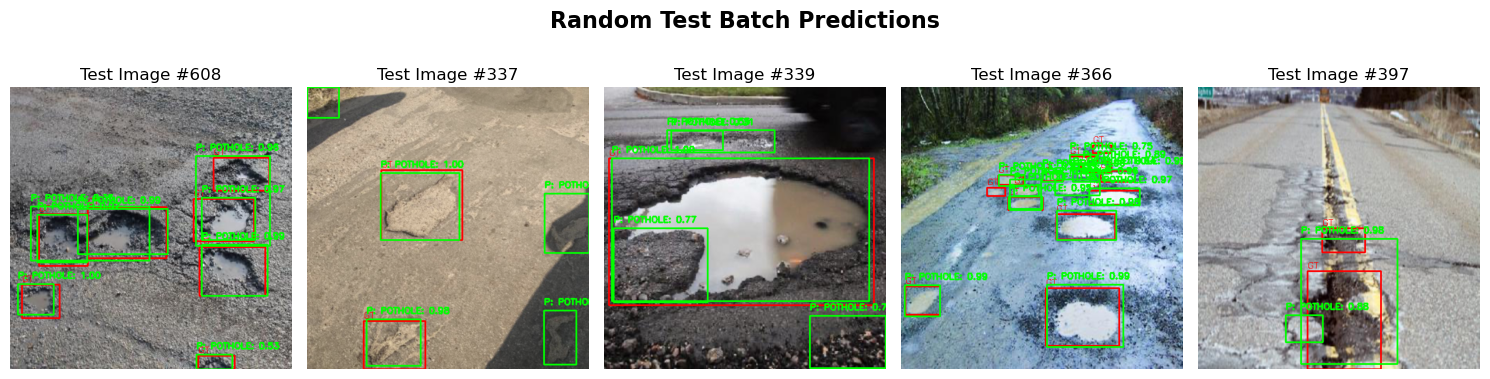

In [67]:
# Load the trained model
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights=None, num_classes=len(PotholeSeverity)) 
state_dict = torch.load("faster_rcnn_pothole.pth", weights_only=True)
model.load_state_dict(state_dict)
model.to(device)  # Move the model to the GPU
model.eval()  # Set the model to evaluation mode

# Define the TestLoader
test_loader = DataLoader(test_set, batch_size=5, shuffle=True, collate_fn=collate_fn)

# Evaluate the model on the test set
threshold = 0.3
all_predictions = evaluate_model(model, test_loader, threshold=threshold)

# Visualize a random test batch
random_batch = random.choice(list(test_loader))  # Select a random batch
images, targets = random_batch

visualize_predictions(images, targets, all_predictions, threshold=threshold, show_severity=True)



## Part 3 - ViT

In [ ]:
# Load the trained model
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights=None, num_classes=len(PotholeSeverity)) 
state_dict = torch.load("faster_rcnn_pothole.pth", weights_only=True)
model.load_state_dict(state_dict)
model.to(device)  # Move the model to the GPU
model.eval()  # Set the model to evaluation mode

# Define the TestLoader
test_loader = DataLoader(test_set, batch_size=5, shuffle=True, collate_fn=collate_fn)

# Function to calculate test score (e.g., mean Average Precision)
def evaluate_model(model, data_loader, threshold=0.5):
    model.eval()  # Ensure the model is in evaluation mode
    all_predictions = {}
    all_ground_truths = {}
    
    with torch.no_grad():
        for batch_idx, (images, targets) in enumerate(data_loader):
            # Prepare images for inference
            inputs = [img.to(device) for img in images]
            
            # Run model inference
            outputs = model(inputs)
            
            # Collect predictions and ground truth
            for i, (output, target) in enumerate(zip(outputs, targets)):
                image_id = target["image_id"].item()
                gt_boxes = target["boxes"].cpu().numpy().tolist()
                
                predictions = [
                    (box.tolist(), label.item(), score.item())
                    for box, label, score in zip(output['boxes'], output['labels'], output['scores'])
                    if score >= threshold
                ]
                all_predictions[image_id] = predictions
                all_ground_truths[image_id] = gt_boxes
            
    return all_predictions, all_ground_truths

def visualize_predictions(images, targets, all_predictions, show_severity=False):
    fig, axs = plt.subplots(1, len(images), figsize=(15, 5))

    for i, (img, target) in enumerate(zip(images, targets)):
        img_np = img.cpu().permute(1, 2, 0).numpy()  # Move tensor to CPU to convert it to (H, W, C) format
        img_np = (img_np * 255).astype(np.uint8).copy()  # Scale and convert to uint8
        
        # Draw ground truth boxes (blue)
        for box, label in zip(target['boxes'], target['labels']):
            x1, y1, x2, y2 = map(int, box)
            cv2.rectangle(img_np, 
                         (x1, y1), 
                         (x2, y2), 
                         (0, 0, 255), 2)  # Blue box, thickness=2
            if show_severity:
                cv2.putText(img_np, 
                            f"GT: {get_label_name(label.item())}", 
                            (x1, y1 - 10), 
                            cv2.FONT_HERSHEY_SIMPLEX, 
                            0.5, 
                            (0, 0, 255), 2)  # Blue text, thickness=2
        
        # Access predictions using the image_id
        idx = target['image_id'].item()
        predictions = all_predictions.get(idx, [])

        # DEBUG:
        print(f"Predictions for Image {idx}: {predictions}")
        
        # Draw predictions (green)
        for pred_box, label, score in predictions:
            xmin, ymin, xmax, ymax = map(int, pred_box)
            cv2.rectangle(img_np, 
                         (xmin, ymin), 
                         (xmax, ymax), 
                         (0, 255, 0), 2)  # Green box, thickness=2
            if show_severity:
                cv2.putText(img_np, 
                            f"P: {get_label_name(label.item())}", 
                            (xmin, ymin - 10), 
                            cv2.FONT_HERSHEY_SIMPLEX, 
                            0.5, 
                            (0, 255, 0), 2)  # Green text, thickness=2
            else:
                cv2.putText(img_np, 
                    f"P: {score:.2f}", 
                    (xmin, ymax + 5), 
                    cv2.FONT_HERSHEY_SIMPLEX, 
                    0.5, 
                    (0, 255, 0), 1)
        
        axs[i].imshow(img_np)
        axs[i].axis("off")
        axs[i].set_title(f"Test Image #{idx}")

    # Add a main title
    plt.suptitle("Test Batch Predictions with Severity" if show_severity else "Test Batch Predictions", 
                 fontsize=16, fontweight="bold")
    plt.show()


# Evaluate the model on the test set
all_predictions, all_ground_truths = evaluate_model(model, test_loader, threshold=0.5)

# Print test results with severity tags
visualize_predictions(images, targets, all_predictions, show_severity=True)

## Part 4 - Smearing Noise

## Conclusions